In [ ]:
#### import packages ####

# os stuff
import sys
import os

#pandas and numpy
import pandas as pd
import numpy as np

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

#sklearn packages
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report

#XGBoost
import xgboost
from xgboost import XGBClassifier

In [ ]:
#LightGBM
import lightgbm
from lightgbm import LGBMClassifier

#install and implement Catboost
!pip install catboost
import catboost
from catboost import CatBoostClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set paths for preprocessor
sys.path.append('/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/')

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from feature_engineer import (
    VandalismScorer,
    is_IP,
    account_age,
    comment_empty,
    word_count,
)

from feature_engineer import preprocessor

In [ ]:
#read the dataset
df = pd.read_csv("/content/drive/MyDrive/Erdos/Project/summer-2025-hoax-detection/Data/train.csv")
preprocessor(df)

In [ ]:
#select features and target
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted','EditId','added_lines','deleted_lines']
target = 'isvandalism'

In [ ]:
df_tt, df_ho = train_test_split(df, test_size=0.2, random_state=42, stratify=df['isvandalism'],shuffle=True)

scorer = VandalismScorer(n_splits=5, random_state=42)
df_tt = scorer.fit_transform(df_tt, df_tt['isvandalism'])
df_ho = scorer.transform(df_ho)

# Now update features (drop EditId, but include the new score)
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score']  # <-- add this

# Models with optimized hyperparameters

In [ ]:
## Make Base Models
# use the results of individual runs to get the optimal hyperparameters of each

xgb = XGBClassifier(max_depth= 9,
                    min_child_weight= 7,
                     gamma= 1.9024978934955494,
                     subsample= 0.7359660928342937,
                     colsample_bytree= 0.8765862797052864,
                     colsample_bylevel= 0.8791472442402003,
                     reg_alpha= 1.8456128259583087,
                     learning_rate= 0.056462992736512986,
                     n_estimators= 760)

lgb = LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26, n_estimators=570, max_depth=9, verbosity=-1)

cat = CatBoostClassifier(depth= 5,
                    l2_leaf_reg= 1.5267386560861382,
                    learning_rate= 0.06106667366524486,
                    iterations= 558,
                    subsample= 0.6203761743592232,
                    random_strength= 0.0020866703079455346,
                    bagging_temperature= 0.006408658178816085,
                    border_count= 63,logging_level='Silent')

In [ ]:
voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

# Cross Validation

In [ ]:
#cross validation

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.features]
scoring = {
    'accuracy' : make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall'   : make_scorer(recall_score),
    'f1_score' : make_scorer(f1_score)
}

nfeatures = [
    'user_edit_count', 'user_distinct_pages', 'user_warns', 'num_edits_5d_before',
    'is_person', 'current_minor', 'account_age', 'comment_empty',
    'is_IP', 'word_count_added', 'word_count_deleted', 'vandalism_score'
]

#unfit models
xgb_model = XGBClassifier(max_depth= 9,
                    min_child_weight= 7,
                     gamma= 1.9024978934955494,
                     subsample= 0.7359660928342937,
                     colsample_bytree= 0.8765862797052864,
                     colsample_bylevel= 0.8791472442402003,
                     reg_alpha= 1.8456128259583087,
                     learning_rate= 0.056462992736512986,
                     n_estimators= 760)

lgb_model = LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26,
                           n_estimators=570, max_depth=9, verbosity=-1)

cat_model = CatBoostClassifier(depth= 5,
                    l2_leaf_reg= 1.5267386560861382,
                    learning_rate= 0.06106667366524486,
                    iterations= 558,
                    subsample= 0.6203761743592232,
                    random_strength= 0.0020866703079455346,
                    bagging_temperature= 0.006408658178816085,
                    border_count= 63,logging_level='Silent')


# Pipelines
pipelines = {
    'XGBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', xgb_model)
    ]),
    'LightGBM': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', lgb_model)
    ]),
    'CatBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', cat_model)
    ]),
    'VotingClassifier': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', VotingClassifier([
            ('xgb', XGBClassifier(max_depth= 9,
                    min_child_weight= 7,
                     gamma= 1.9024978934955494,
                     subsample= 0.7359660928342937,
                     colsample_bytree= 0.8765862797052864,
                     colsample_bylevel= 0.8791472442402003,
                     reg_alpha= 1.8456128259583087,
                     learning_rate= 0.056462992736512986,
                     n_estimators= 760)),
            ('lgb', LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26,
                           n_estimators=570, max_depth=9, verbosity=-1)),
            ('cat', CatBoostClassifier(depth= 5,
                    l2_leaf_reg= 1.5267386560861382,
                    learning_rate= 0.06106667366524486,
                    iterations= 558,
                    subsample= 0.6203761743592232,
                    random_strength= 0.0020866703079455346,
                    bagging_temperature= 0.006408658178816085,
                    border_count= 63,logging_level='Silent'))
        ], voting='hard'))
    ])
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate all
for name, pipeline in pipelines.items():
    print(f"\n{name} Scores:")
    results = cross_validate(
        pipeline, df.copy(), df['isvandalism'].copy(),
        cv=cv, scoring=scoring
    )
    for metric in scoring.keys():
        print(f"{metric}: {results[f'test_{metric}'].mean():.4f}")


XGBoost Scores:
accuracy: 0.9149
precision: 0.9261
recall: 0.8968
f1_score: 0.9112

LightGBM Scores:
accuracy: 0.9142
precision: 0.9261
recall: 0.8952
f1_score: 0.9103

CatBoost Scores:
accuracy: 0.9138
precision: 0.9267
recall: 0.8938
f1_score: 0.9099

VotingClassifier Scores:
accuracy: 0.9151
precision: 0.9272
recall: 0.8960
f1_score: 0.9113


# Model Fitting on training

xgb_clf training set metrics
Accuracy : 0.9113
Precision: 0.9221
Recall   : 0.8934
F1 Score : 0.9075

Confusion Matrix:
[[2423  187]
 [ 264 2212]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9017    0.9284    0.9149      2610
        True     0.9221    0.8934    0.9075      2476

    accuracy                         0.9113      5086
   macro avg     0.9119    0.9109    0.9112      5086
weighted avg     0.9116    0.9113    0.9113      5086



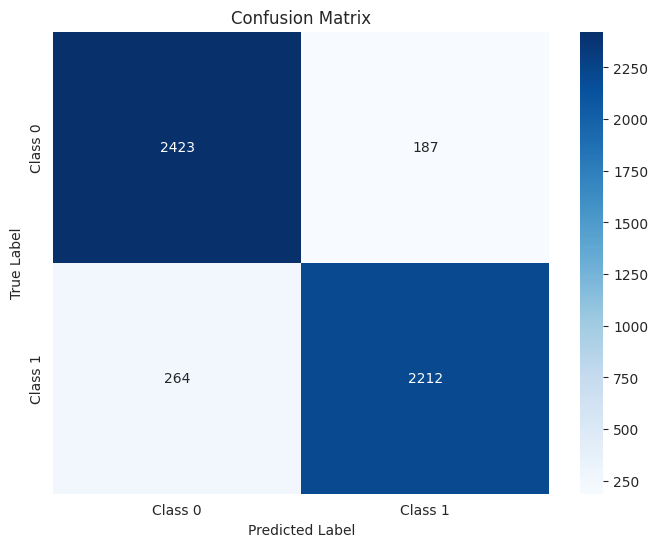

lgb_clf training set metrics
Accuracy : 0.9117
Precision: 0.9242
Recall   : 0.8918
F1 Score : 0.9077

Confusion Matrix:
[[2429  181]
 [ 268 2208]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9006    0.9307    0.9154      2610
        True     0.9242    0.8918    0.9077      2476

    accuracy                         0.9117      5086
   macro avg     0.9124    0.9112    0.9116      5086
weighted avg     0.9121    0.9117    0.9117      5086



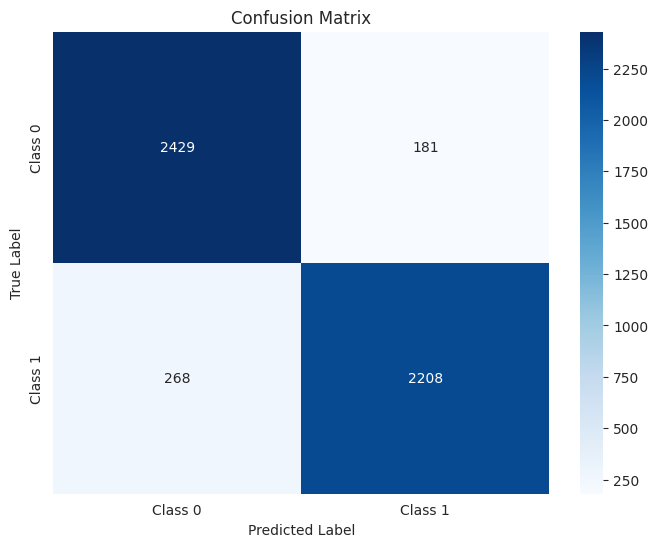

cat_clf training set metrics
Accuracy : 0.9113
Precision: 0.9210
Recall   : 0.8946
F1 Score : 0.9076

Confusion Matrix:
[[2420  190]
 [ 261 2215]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9026    0.9272    0.9148      2610
        True     0.9210    0.8946    0.9076      2476

    accuracy                         0.9113      5086
   macro avg     0.9118    0.9109    0.9112      5086
weighted avg     0.9116    0.9113    0.9113      5086



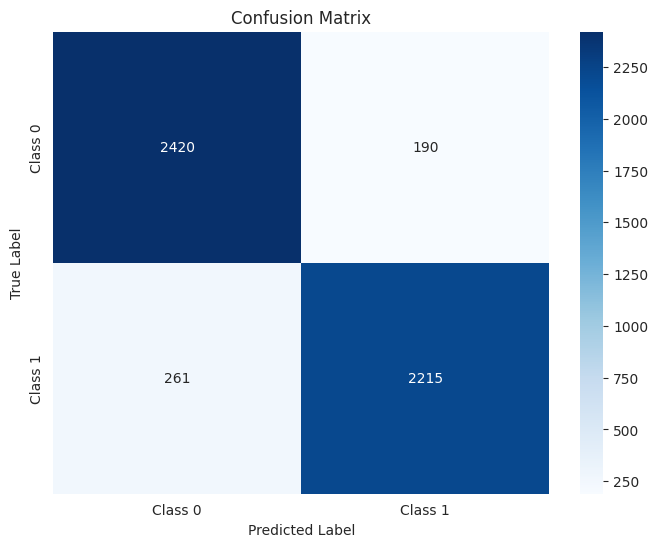

voting_clf training set metrics
Accuracy : 0.9119
Precision: 0.9232
Recall   : 0.8934
F1 Score : 0.9080

Confusion Matrix:
[[2426  184]
 [ 264 2212]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9019    0.9295    0.9155      2610
        True     0.9232    0.8934    0.9080      2476

    accuracy                         0.9119      5086
   macro avg     0.9125    0.9114    0.9118      5086
weighted avg     0.9123    0.9119    0.9119      5086



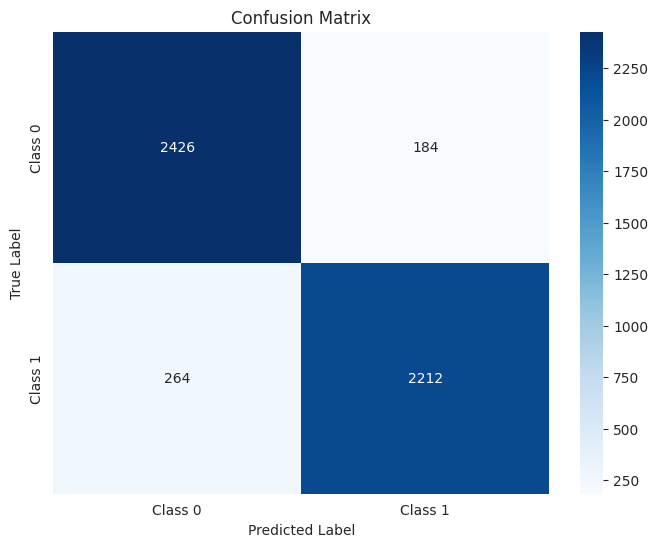


Best model: voting_clf with accuracy 0.91192


In [ ]:
best_name = None
best_acc = 0
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score']

#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    accuracy = accuracy_score(df_ho.isvandalism, y_pred)
    precision = precision_score(df_ho.isvandalism, y_pred)
    recall = recall_score(df_ho.isvandalism, y_pred)
    f1 = f1_score(df_ho.isvandalism, y_pred)
    confmat = confusion_matrix(df_ho.isvandalism, y_pred)

    # Print metrics
    print(name,"training set metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confmat)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_ho.isvandalism, y_pred, digits=4))

    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # update best
    if accuracy > best_acc:
        best_acc = accuracy
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")


Note: when running xbg and lgb with optimized hyperparameters and catboost with default parameters, we got


```
xgb_clf training set accuracy 0.92686
lgb_clf training set accuracy 0.92489
cat_clf training set accuracy 0.92587
voting_clf training set accuracy 0.92764

Best model: voting_clf with accuracy 0.92764
```



# Models with Default Parameters on training set

xgb_clf training set metrics
Accuracy : 0.9133
Precision: 0.9227
Recall   : 0.8970
F1 Score : 0.9097

Confusion Matrix:
[[2424  186]
 [ 255 2221]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9048    0.9287    0.9166      2610
        True     0.9227    0.8970    0.9097      2476

    accuracy                         0.9133      5086
   macro avg     0.9138    0.9129    0.9132      5086
weighted avg     0.9135    0.9133    0.9132      5086



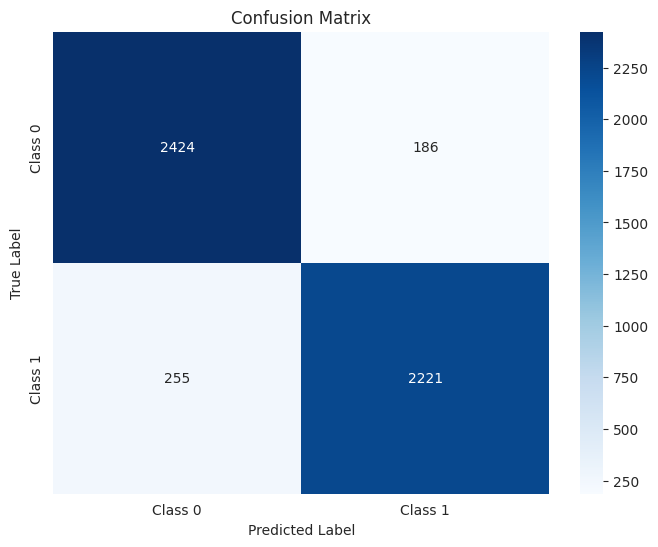

lgb_clf training set metrics
Accuracy : 0.9123
Precision: 0.9233
Recall   : 0.8942
F1 Score : 0.9085

Confusion Matrix:
[[2426  184]
 [ 262 2214]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9025    0.9295    0.9158      2610
        True     0.9233    0.8942    0.9085      2476

    accuracy                         0.9123      5086
   macro avg     0.9129    0.9118    0.9122      5086
weighted avg     0.9126    0.9123    0.9123      5086



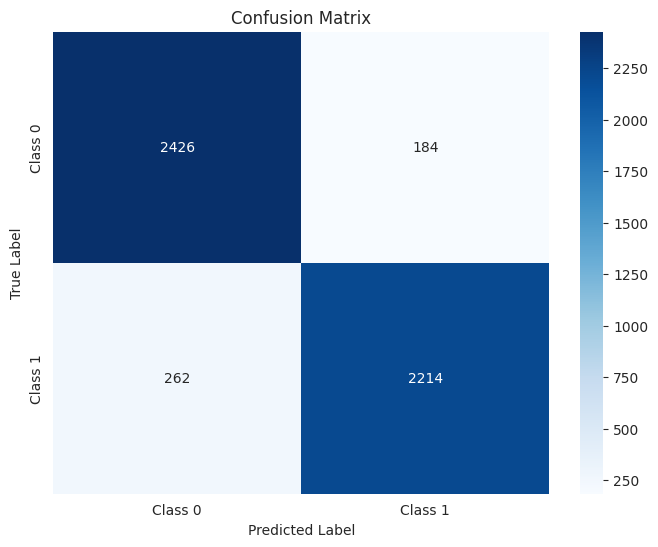

cat_clf training set metrics
Accuracy : 0.9143
Precision: 0.9254
Recall   : 0.8962
F1 Score : 0.9105

Confusion Matrix:
[[2431  179]
 [ 257 2219]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9044    0.9314    0.9177      2610
        True     0.9254    0.8962    0.9105      2476

    accuracy                         0.9143      5086
   macro avg     0.9149    0.9138    0.9141      5086
weighted avg     0.9146    0.9143    0.9142      5086



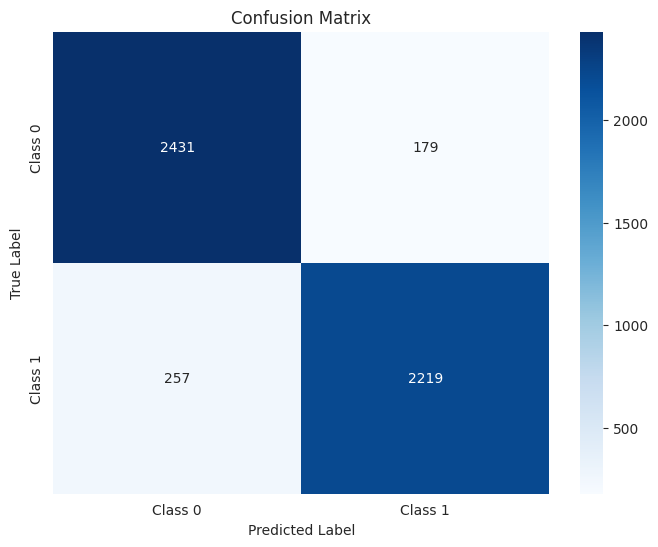

voting_clf training set metrics
Accuracy : 0.9125
Precision: 0.9240
Recall   : 0.8938
F1 Score : 0.9086

Confusion Matrix:
[[2428  182]
 [ 263 2213]]

Classification Report:
              precision    recall  f1-score   support

       False     0.9023    0.9303    0.9161      2610
        True     0.9240    0.8938    0.9086      2476

    accuracy                         0.9125      5086
   macro avg     0.9131    0.9120    0.9123      5086
weighted avg     0.9129    0.9125    0.9124      5086



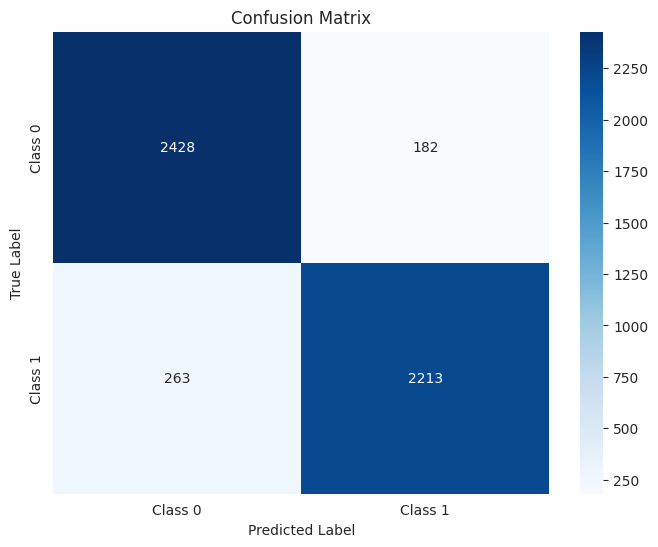


Best model: cat_clf with accuracy 0.91427


In [ ]:
#Models with default parameters

xgb = XGBClassifier()

lgb = LGBMClassifier(verbosity=-1)

cat = CatBoostClassifier(logging_level='Silent')

voting = VotingClassifier([('xgb',xgb),
                           ('lgb',lgb),
                           ('cat',cat)],
                         voting='hard')

best_name = None
best_acc = 0
features = ['user_edit_count','user_distinct_pages','user_warns','num_edits_5d_before',
            'is_person','current_minor','account_age','comment_empty',
            'is_IP','word_count_added','word_count_deleted',
            'vandalism_score']

#fit each model and print their accuracy, then print the best accuracy score
for name,clf in (["xgb_clf",xgb],
                 ["lgb_clf",lgb],
                 ["cat_clf",cat],
                 ["voting_clf",voting]):
    # fit the model
    clf.fit(df_tt[features], df_tt.isvandalism)

    # predict
    y_pred = clf.predict(df_ho[features])

    # get acc
    accuracy = accuracy_score(df_ho.isvandalism, y_pred)
    precision = precision_score(df_ho.isvandalism, y_pred)
    recall = recall_score(df_ho.isvandalism, y_pred)
    f1 = f1_score(df_ho.isvandalism, y_pred)
    confmat = confusion_matrix(df_ho.isvandalism, y_pred)

    # Print metrics
    print(name,"training set metrics")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\nConfusion Matrix:")
    print(confmat)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(df_ho.isvandalism, y_pred, digits=4))

    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Class 0', 'Class 1'], # Replace with your actual class labels
                    yticklabels=['Class 0', 'Class 1']) # Replace with your actual class labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # update best
    if accuracy > best_acc:
        best_acc = accuracy
        best_name = name

print(f"\nBest model: {best_name} with accuracy {np.round(best_acc, 5)}")

In [ ]:
# Train/test split
X = df.copy()
y = df['isvandalism'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

#pipelines
pipelines = {
    'XGBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', xgb_model)
    ]),
    'LightGBM': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', lgb_model)
    ]),
    'CatBoost': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', cat_model)
    ]),
    'VotingClassifier': Pipeline([
        ('scorer', VandalismScorer(n_splits=5, random_state=42)),
        ('select', FeatureSelector(nfeatures)),
        ('model', VotingClassifier([
            ('xgb', XGBClassifier(max_depth= 9,
                    min_child_weight= 7,
                     gamma= 1.9024978934955494,
                     subsample= 0.7359660928342937,
                     colsample_bytree= 0.8765862797052864,
                     colsample_bylevel= 0.8791472442402003,
                     reg_alpha= 1.8456128259583087,
                     learning_rate= 0.056462992736512986,
                     n_estimators= 760)),
            ('lgb', LGBMClassifier(learning_rate= 0.027425528114638015, num_leaves= 26,
                           n_estimators=570, max_depth=9, verbosity=-1)),
            ('cat', CatBoostClassifier(depth= 5,
                    l2_leaf_reg= 1.5267386560861382,
                    learning_rate= 0.06106667366524486,
                    iterations= 558,
                    subsample= 0.6203761743592232,
                    random_strength= 0.0020866703079455346,
                    bagging_temperature= 0.006408658178816085,
                    border_count= 63,logging_level='Silent'))
        ], voting='hard'))
    ])
}


# Thresholds to evaluate
thresholds = np.linspace(0.0, 1.0, 200)

# For storing results
threshold_results = {}

for name, pipeline in pipelines.items():
    print(f"\nFitting {name}...")

    # Replace hard voting with soft for threshold testing
    if name == 'VotingClassifier':
        pipeline.set_params(model__voting='soft')

    # Fit model
    pipeline.fit(X_train, y_train)

    # Predict probabilities
    proba = pipeline.predict_proba(X_test)[:, 1]  # class 1 probability

    # Evaluate at different thresholds
    f1s, precisions, recalls,accuracies = [], [], [],[]
    for t in thresholds:
        pred = (proba >= t).astype(int)
        f1s.append(f1_score(y_test, pred))
        precisions.append(precision_score(y_test, pred, zero_division=0))
        recalls.append(recall_score(y_test, pred))
        accuracies.append(accuracy_score(y_test,pred))

    # Store results
    threshold_results[name] = {
        'thresholds': thresholds,
        'f1': f1s,
        'precision': precisions,
        'recall': recalls,
        'accuracy': accuracies,
        'best_threshold': thresholds[np.argmax(f1s)],
        'best_f1': max(f1s)
    }

    # Print best threshold
    print(f"Best threshold (F1): {threshold_results[name]['best_threshold']:.3f}")
    print(f"F1: {threshold_results[name]['best_f1']:.3f}")
    print(f"Precision: {precisions[np.argmax(f1s)]:.3f}")
    print(f"Recall: {recalls[np.argmax(f1s)]:.3f}")
    print(f"Accuracy: {accuracies[np.argmax(f1s)]:.3f}")


Fitting XGBoost...
Best threshold (F1): 0.367
F1: 0.911
Precision: 0.897
Recall: 0.925
Accuracy: 0.912

Fitting LightGBM...
Best threshold (F1): 0.347
F1: 0.910
Precision: 0.893
Recall: 0.928
Accuracy: 0.911

Fitting CatBoost...
Best threshold (F1): 0.407
F1: 0.909
Precision: 0.901
Recall: 0.916
Accuracy: 0.911

Fitting VotingClassifier...


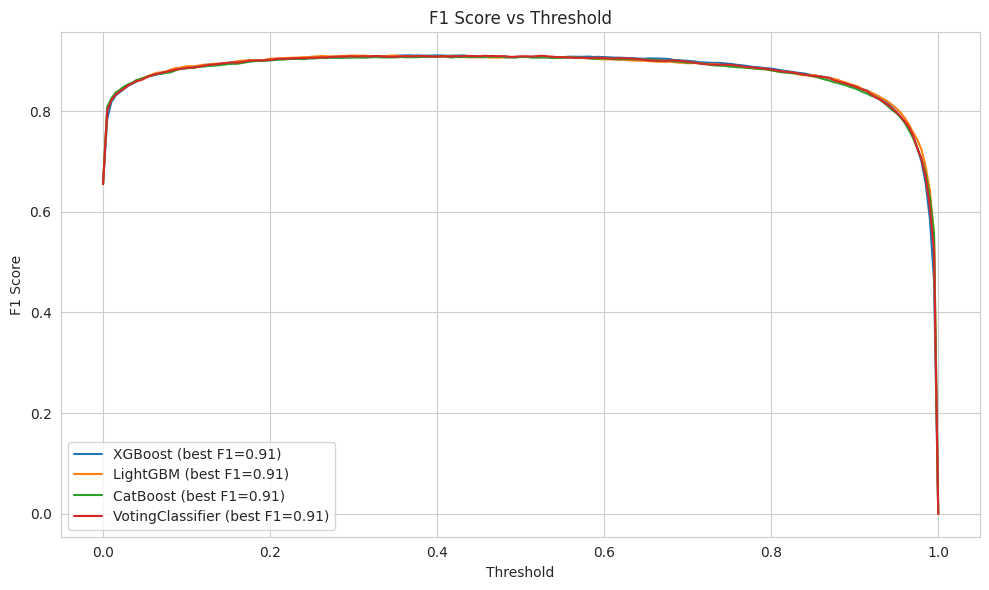

In [25]:
# Plot F1 curves for all models
plt.figure(figsize=(10, 6))
for name, res in threshold_results.items():
    plt.plot(res['thresholds'], res['f1'], label=f'{name} (best F1={res["best_f1"]:.2f})')
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("my_plot.png")
plt.show()
